In [1]:
import random
import tensorflow as tf
import keras
import cv2
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications import Xception
from keras.models import Model
from keras import layers, backend, metrics
from keras.layers import Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D, Lambda
import time
from tensorflow.keras.applications.inception_v3 import preprocess_input
import math
import os
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize

In [ ]:
ROOT = "data/Extracted Faces/Extracted Faces"
#os.mkdir("file")
def read_image(index):
    path = os.path.join(ROOT, index[0], index[1])
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

In [ ]:
def split_dataset(directory, split=0.9):
    folders=os.listdir(directory)
    num_train=int(len(folders)*split)
    random.shuffle(folders)
    train_list, test_list = {}, {}
    for folder in folders[:num_train]:
        num_files = len(os.listdir(os.path.join(directory, folder)))
        train_list[folder] = num_files
    for folder in folders[num_train:]:
        num_files = len(os.listdir(os.path.join(directory, folder)))
        test_list[folder] = num_files  
    
    return train_list, test_list
train_list, test_list = split_dataset(ROOT, split=0.9)

print("Length of training list:", len(train_list))
print("Length of testing list :", len(test_list))

In [4]:
def create_triplets(directory, folder_list, max_files=10):
    triplets = []
    folders = list(folder_list.keys())
    for folder in folders:
        path = os.path.join(directory, folder)
        files = list(os.listdir(path))[:max_files]
        num_files = len(files)
        for i in range(num_files-1):
            for j in range(i+1, num_files):
                anchor = (folder, f"{i}.jpg")
                positive = (folder, f"{j}.jpg")
                neg_folder = folder
                while neg_folder == folder:
                    neg_folder = random.choice(folders)
                neg_file = random.randint(0, folder_list[neg_folder]-1)
                negative = (neg_folder, f"{neg_file}.jpg")

                triplets.append((anchor, positive, negative))
            
    random.shuffle(triplets)
    return triplets

In [5]:
train_triplet = create_triplets(ROOT, train_list)
test_triplet  = create_triplets(ROOT, test_list)

print("Number of training triplets:", len(train_triplet))
print("Number of testing triplets :", len(test_triplet))
for i in range(5):
    print(train_triplet[i])

Number of training triplets: 10276
Number of testing triplets : 955
(('1370', '1.jpg'), ('1370', '2.jpg'), ('1583', '0.jpg'))
(('762', '0.jpg'), ('762', '1.jpg'), ('925', '0.jpg'))
(('708', '0.jpg'), ('708', '3.jpg'), ('562', '1.jpg'))
(('616', '7.jpg'), ('616', '9.jpg'), ('1527', '1.jpg'))
(('526', '4.jpg'), ('526', '5.jpg'), ('1356', '1.jpg'))


In [6]:
def get_batch(triplet_list, batch_size=64, preprocess=True):
    batch_steps = len(triplet_list)//batch_size
    
    for i in range(batch_steps+1):
        anchor   = []
        positive = []
        negative = []
        
        j = i*batch_size
        while j<(i+1)*batch_size and j<len(triplet_list):
            a, p, n = triplet_list[j]
            anchor.append(read_image(a))
            positive.append(read_image(p))
            negative.append(read_image(n))
            j+=1
            
        anchor = np.array(anchor)
        positive = np.array(positive)
        negative = np.array(negative)
        
        if preprocess:
            anchor = preprocess_input(anchor)
            positive = preprocess_input(positive)
            negative = preprocess_input(negative)
        
        yield ([anchor, positive, negative])

In [7]:
def get_encoder(input_shape):
    
    pretrained=Xception(
        input_shape=input_shape,
        weights='imagenet',
        include_top=False,
        pooling='avg',
    )
    for i in range(len(pretrained.layers)-27):
        pretrained.layers[i].trainable = False
    
    encoder=tf.keras.Sequential([
        pretrained,
        Flatten(),
        Dense(512,activation="relu"),
        BatchNormalization(),
        Dense(256,activation="relu"),
        tf.keras.layers.Lambda(lambda x : tf.math.l2_normalize(x, axis=1))
    ])
    return encoder

In [8]:
class Distance_layer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        
    def call(self,anchor,positive,negative):
        ap_dist=tf.reduce_sum(tf.square(anchor-positive),-1)
        an_dist=tf.reduce_sum(tf.square(anchor-negative),-1)
        return (ap_dist, an_dist)

In [9]:
def siamese_network(input_shape=(128,128,3)):
    encoder = get_encoder(input_shape)
    
    anchor_input=layers.Input(input_shape,name="anchor")
    positive_input=layers.Input(input_shape,name="positive")
    negative_input=layers.Input(input_shape,name="negative")
    
    anchor = encoder(anchor_input)
    positive = encoder(positive_input)
    negative = encoder(negative_input)
    
    distances = Distance_layer()(
        anchor,
        positive,
        negative
    )
    network = Model(
        inputs  = [anchor_input, positive_input, negative_input],
        outputs = distances,
        name = "Siamese_Network"
    )
    return network

In [10]:
siamese_network = siamese_network()
siamese_network.summary()

Model: "Siamese_Network"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 anchor (InputLayer)            [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 positive (InputLayer)          [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 negative (InputLayer)          [(None, 128, 128, 3  0           []                               
                                )]                                                  

In [11]:
class siamese_model(Model):
    def __init__(self, siamese_network, margin=1.0):
        super(siamese_model, self).__init__()
        self.network=siamese_network
        self.margin=margin
        self.loss_tracker = metrics.Mean(name="loss")
    def call(self,input_):
        return self.network(input_)
    def train_step(self,data):
        with tf.GradientTape() as tape:
            loss=self._compute_loss(data)
        gradients=tape.gradient(loss,self.network.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.network.trainable_weights))
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}
    def test_step(self, data):
        loss = self._compute_loss(data)
        
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}
    def _compute_loss(self, data):
        # Get the two distances from the network, then compute the triplet loss
        ap_distance, an_distance = self.network(data)
        loss = tf.maximum(ap_distance - an_distance + self.margin, 0.0)
        return loss
    @property
    def metrics(self):
        # We need to list our metrics so the reset_states() can be called automatically.
        return [self.loss_tracker]

In [12]:
def test_on_triplets(batch_size = 4):
    pos_scores, neg_scores = [], []

    for data in get_batch(test_triplet, batch_size=batch_size):
        prediction = siamese_model.predict(data)
        pos_scores += list(prediction[0])
        neg_scores += list(prediction[1])
    
    accuracy = np.sum(np.array(pos_scores) < np.array(neg_scores)) / len(pos_scores)
    ap_mean = np.mean(pos_scores)
    an_mean = np.mean(neg_scores)
    ap_stds = np.std(pos_scores)
    an_stds = np.std(neg_scores)
    
    print(f"Accuracy on test = {accuracy:.5f}")
    return (accuracy, ap_mean, an_mean, ap_stds, an_stds)

In [13]:
siamese_model = siamese_model(siamese_network)

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3, epsilon=1e-01)
siamese_model.compile(optimizer=optimizer)

In [14]:
save_all = False
epochs = 2
batch_size = 8

max_acc = 0
train_loss = []
test_metrics = []

for epoch in range(1, epochs+1):
    t = time.time()
    
    # Training the model on train data
    epoch_loss = []
    for data in get_batch(train_triplet, batch_size=batch_size):
        loss = siamese_model.train_on_batch(data)
        epoch_loss.append(loss)
    epoch_loss = sum(epoch_loss)/len(epoch_loss)
    train_loss.append(epoch_loss)

    print(f"\nEPOCH: {epoch} \t (Epoch done in {int(time.time()-t)} sec)")
    print(f"Loss on train    = {epoch_loss:.5f}")
    
    # Testing the model on test data
    metric = test_on_triplets(batch_size=batch_size)
    test_metrics.append(metric)
    accuracy = metric[0]


EPOCH: 1 	 (Epoch done in 918 sec)
Loss on train    = 0.45384
1/1 [==============================] - 0s 157ms/step
Accuracy on test = 0.86911

EPOCH: 2 	 (Epoch done in 921 sec)
Loss on train    = 0.28544
1/1 [==============================] - 0s 138ms/step
Accuracy on test = 0.87539


In [15]:
def extract_encoder(model):
    encoder = get_encoder((128, 128, 3))
    i=0
    for e_layer in model.layers[0].layers[3].layers:
        layer_weight = e_layer.get_weights()
        encoder.layers[i].set_weights(layer_weight)
        i+=1
    return encoder

encoder = extract_encoder(siamese_model)
encoder.save("InceptionV3.h5")
encoder.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 512)               1049088   
                                                                 
 batch_normalization_9 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dense_3 (Dense)             (None, 256)               131328    
                                                                 
 lambda_1 (Lambda)           (None, 256)               0         
                                                      

In [2]:
encoder=tf.keras.models.load_model("InceptionV3.h5")

In [3]:
encoder.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 512)               1049088   
                                                                 
 batch_normalization_9 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dense_3 (Dense)             (None, 256)               131328    
                                                                 
 lambda_1 (Lambda)           (None, 256)               0         
                                                      

In [15]:
def classify_images(face1,face2,threshold=0.4):
    tensor1=encoder(face1)
    tensor2=encoder(face2)
    dist=np.sum(np.square(tensor1-tensor2), axis=-1)
    pred=(dist<threshold,0,1)
    return pred

In [16]:
def read_image(path):
    image=cv2.imread(path)
    image=resize(image,(128,128))
    return image

In [17]:
os.listdir()

['.ipynb_checkpoints',
 '20230124_195957.jpg',
 '20230309_143407.jpg',
 'archive.zip',
 'data',
 'face recognition .ipynb',
 'haarcascade_frontalface_default.xml',
 'InceptionV3.h5',
 'Untitled.ipynb',
 'WhatsApp Image 2023-03-09 at 1.29.31 PM.jpg']

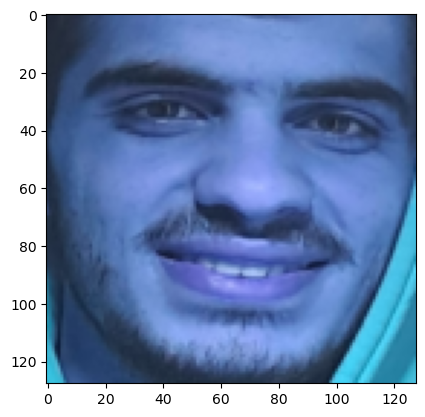

In [18]:
face_1=read_image("20230124_195957.jpg")
plt.imshow(face_1)
plt.show()

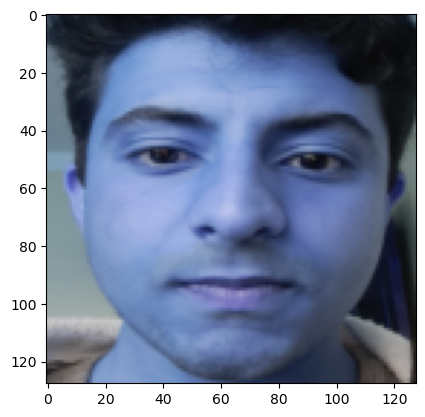

In [19]:
face_2=read_image("20230309_143407.jpg")
plt.imshow(face_2)
plt.show()

In [20]:
classify_images(np.expand_dims(face_1,axis=0),np.expand_dims(face_2,axis=0))

(array([False]), 0, 1)

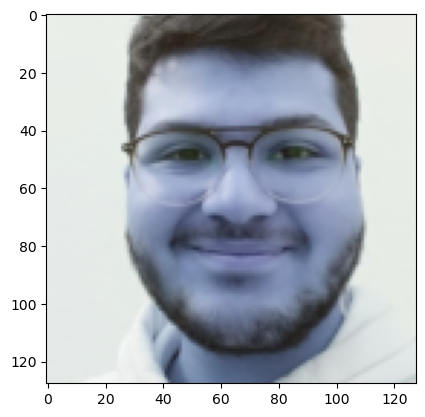

In [21]:
face_1=read_image("WhatsApp Image 2023-03-09 at 1.29.31 PM.jpg")
plt.imshow(face_1)
plt.show()

In [22]:
classify_images(np.expand_dims(face_1,axis=0),np.expand_dims(face_2,axis=0))

(array([False]), 0, 1)

In [23]:
classify_images(np.expand_dims(face_2,axis=0),np.expand_dims(face_2,axis=0))

(array([ True]), 0, 1)